# Pytorch Object Discovery Autoencoder

Notebook from **Lukas Heinrich** implementing the [slot attention](https://arxiv.org/abs/2006.15055) module for object discovery in pytorch.

Summer 2023

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [25]:
torch.cuda.is_available()

False

In [2]:
torch.__version__

'2.0.1'

In [3]:
def gen_data():
    bins = [np.linspace(-7,7,41)]*2
    _ed = np.linspace(-7,7,41)
    _ct = _ed[:-1] + np.diff(_ed)/2
    grid = np.meshgrid(*[_ct]*2, indexing='ij')

    
    K = 2
    centers = np.random.uniform(-6,6, size = (K, 2))
    X = np.concatenate([np.random.multivariate_normal(cc,0.2*np.eye(2), size = (1000,)) for cc in centers])
    c,_,_= np.histogram2d(X[:,0], X[:,1], bins = bins)
    c = np.log(c + 1e-2)
    c = np.stack([grid[0],grid[1],grid[0][::-1],grid[1][::-1],c])
    return torch.FloatTensor(c)[None,:], torch.FloatTensor(centers)[None,:]

def make_batch(
        Nbatch = 34,
        data_mean = torch.FloatTensor([0,0,0,0,3]),
        data_std = torch.FloatTensor([1,1,1,1,1])
    ):
    batch = [gen_data() for i in range(Nbatch)]
    data = torch.concat([b[0] for b in batch])
    trgt = torch.concat([b[1] for b in batch])
    
    bkgtrgt = -3*torch.ones(Nbatch,1,2)
    return data, trgt
make_batch(123)[0].shape

torch.Size([123, 5, 40, 40])

In [4]:
class SlotAttentionEncoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.k_slots = 3
        self.latent_dim = 32
        self.hidden_dim = 32
        self.query_dim = 32
        self.slot_dim = 32
        self.n_iter = 1

        self.queryN = torch.nn.LayerNorm(self.query_dim)
        self.dataN = torch.nn.LayerNorm(self.hidden_dim)
        self.updateN = torch.nn.LayerNorm(self.query_dim)

        self.toK = torch.nn.Linear(self.hidden_dim,self.query_dim)
        self.toV = torch.nn.Linear(self.hidden_dim,self.query_dim)
        self.gru = torch.nn.GRUCell(self.query_dim, self.query_dim)

        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(5,self.hidden_dim,5, padding = 2),
#             torch.nn.ReLU(),
#             torch.nn.Conv2d(self.hidden_dim,self.hidden_dim,5, padding = 2),
#             torch.nn.ReLU(),
#             torch.nn.Conv2d(self.hidden_dim,self.hidden_dim,5, padding = 2),
        )   
        
        self.final = torch.nn.Sequential(
            torch.nn.Linear(self.query_dim, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16,self.slot_dim)
        )

        self.updateff = torch.nn.Sequential(
            torch.nn.Linear(self.query_dim, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16,self.query_dim)
        )
        
    def init_slots(self, Nbatch):
        noise = torch.randn(Nbatch, self.k_slots, self.query_dim)
        
        mu = torch.zeros(1,1,self.query_dim)
        logsigma = torch.zeros(1,1,self.query_dim)
        
        return mu + noise*logsigma.exp()


    def attention_and_weights(self,queries,encoded_data):
        keys = self.toK(encoded_data)
        # einsum is a fancy way to do matrix multiplication with einstein notation
        att = torch.einsum('bse,bde->bsd',queries,keys) * (self.query_dim ** (-0.5)) * 10
        # att has shape, (Nbatch, K, inpt_img_dim)
        
        # Want to normalize over the _slots_
        att = torch.nn.functional.softmax(att, dim = 1) # now att has shape (Nbat)
        # To compute the weighted mean, look at the normalization over the inputs
        div = torch.sum(att, dim = -1, keepdims = True)
        
        wts = att/div + 1e-8
        return att,wts

    def iterate(self, queries, encoded_data):
        encoded_data = torch.permute(encoded_data,(0,2,3,1))
        encoded_data = torch.flatten(encoded_data,1,2) # Flatten the 2d img into a single dim
        encoded_data = self.dataN(encoded_data)
        
        att,wts = self.attention_and_weights(self.queryN(queries),encoded_data)        
        vals = self.toV(encoded_data)
        extracted = torch.einsum('bsd,bde->bse',wts,vals)
        
        extracted = self.gru(
            extracted.reshape(-1,self.query_dim),
            queries.reshape(-1,self.query_dim),
        )

        extracted = extracted.reshape(queries.shape)
        return extracted + self.updateff(self.updateN(extracted))
    
    def forward(self, data):
        Nbatch = data.shape[0]
        queries = self.init_slots(Nbatch)
        encoded_data = self.encoder(data)
        queries = self.iterate(queries, encoded_data)
        queries = self.iterate(queries, encoded_data)
        positions = self.final(queries)
        return positions,queries
        
SlotAttentionEncoder()(torch.randn(123,5,40,40))[0].shape

torch.Size([123, 3, 32])

In [5]:
class AttModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.latent_dim = 32

        self.encoder = SlotAttentionEncoder()
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(self.latent_dim,128),
            torch.nn.ReLU(),
            torch.nn.Linear(128,256),
            torch.nn.ReLU(),
            torch.nn.Linear(256,40*40),
            torch.nn.Unflatten(-1,(40,40))
        )
        

    def forward(self, data):
        Nbatch, *_ = data.shape
        positions,queries = self.encoder(data)
#         print('positions',positions.shape)
#         print('queries',queries.shape)
        
        decoded = self.decoder(positions)
        reco = decoded.sum(dim = 1)
        
#         print('decoded',decoded.shape)
#         print('reco',reco.shape)
        
        return reco,queries,decoded

    
X, Y = make_batch(123)
model = AttModel()

positions, queries = model.encoder(X) #[0].shape


out = model(X) #[0].shape



In [6]:
# # Taken from the iterate() block of SlotAttnetionEncoder
# encoded_data = torch.permute(encoded_data,(0,2,3,1))
# encoded_data = torch.flatten(encoded_data,1,2) # Flatten the 2d img into a single dim
# encoded_data = self.dataN(encoded_data)

# # OK, this is the first step
# att,wts = self.attention_and_weights(self.queryN(queries),encoded_data) 

In [20]:
def plotit(batchidx, model, data, losses):
    
    with torch.no_grad():
        model.eval()
        pred,queries,decoded = model(data)
        encoded_data = model.encoder.encoder(data)
        encoded_data = torch.permute(encoded_data,(0,2,3,1))
        encoded_data = torch.flatten(encoded_data,1,2)
        encoded_data = model.encoder.dataN(encoded_data)
        
        att,wts = model.encoder.attention_and_weights(queries,encoded_data)
        
        # att: (Nbatch, n_slots, raw_img_dim)
        # wts: (Nbatch, n_slots, raw_img_dim)
        
#         print(wts.sum(dim=-1).max(),'max')
        att = att.reshape(len(att),3,40,40)
        wts = wts.reshape(len(att),3,40,40)
        
        crap = model.decoder(torch.randn(2,model.encoder.k_slots,model.encoder.slot_dim))
        
    f,axarr = plt.subplots(3,6)
    
    ax = axarr[0,0]
    ax.set_title('Loss')
    ax.plot(losses)
    ax.set_yscale('log')
    ax.axis('off')
    
    ax = axarr[0,1]
    ax.pcolormesh(data[batchidx,-1], vmin = -3, vmax = 3)
    ax.set_title('Data')
    ax.axis('off')
    
    ax = axarr[0,2]
    ax.pcolormesh(pred[batchidx], vmin = -3, vmax = 3)
    ax.set_title('Reco')
    ax.axis('off')
    
    for i in range(3):
        ax = axarr[0,3+i]
        ax.pcolormesh(att[batchidx,i], vmin = 0, vmax = 1)
        ax.set_title(f'Attn {i}')
        ax.axis('off')
    for i in range(3):
        ax = axarr[1,3+i]
        print('min(w)',wts.min().numpy(),'max(w)',wts.max().numpy(),'>>><<')
        ax.pcolormesh(wts[batchidx,i], vmin = 0, vmax = .001)
        ax.set_title(f'Weight {i}')
        ax.axis('off')
        
    # Turn off the axes that we're not drawing
    for i in range(3):
        ax = axarr[1,i]
        ax.axis('off')
        ax = axarr[2,i]
        ax.axis('off')
        
    ax = axarr[1,0]
    ax.set_title(f'Decode rand')
    ax.pcolormesh(crap[batchidx,0])

    ax = axarr[1,2]
    ax.set_title(f'Sum slots')
    ax.pcolormesh(decoded.sum(dim=1)[batchidx], vmin = -3, vmax = 3)
    for i in range(3):
        ax = axarr[2,3+i]
        ax.pcolormesh(decoded[batchidx,i], vmin = -3, vmax = 3)
        ax.set_title(f'Slot {i}')
        ax.axis('off')
    f.set_size_inches(12,6)
    plt.show()    

def train(model, Ntrain = 5000):
    opt = torch.optim.Adam(model.parameters(), 3e-4)
    model.train()
    losses = []
    for i in range(Ntrain):
        
        warmup_steps = 5000
        learning_rate = 3e-4
        if i < warmup_steps:
            learning_rate = learning_rate * (i / warmup_steps)
        else:
            learning_rate = learning_rate
        opt.param_groups[0]['lr'] = learning_rate

        
        data, trgt = make_batch(4)
        pred,*_ = model(data)
        loss = torch.nn.functional.mse_loss(
            data[:,-1,...],
            pred
        )
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        losses.append(float(loss))
        if i % 250 == 0:
            print('iter',i,', loss',loss.detach().numpy(),', lr',opt.param_groups[0]['lr'])
            plotit(0,model,data,losses)
            plotit(1,model,data,losses)

    model.eval()
    return model,losses

In [21]:
opt = torch.optim.Adam(model.parameters(), 3e-4)
opt.param_groups[0]['lr']

0.0003

In [22]:
model = AttModel()

iter 0 , loss 1.3707128 , lr 0.0
tensor(1.0000e-08) tensor(0.2990) >>><<
tensor(1.0000e-08) tensor(0.2990) >>><<
tensor(1.0000e-08) tensor(0.2990) >>><<


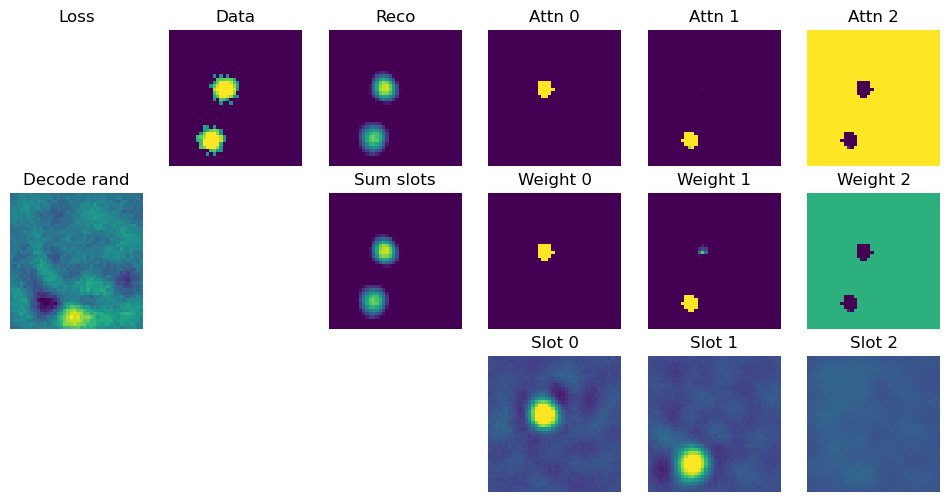

tensor(1.0000e-08) tensor(0.3521) >>><<
tensor(1.0000e-08) tensor(0.3521) >>><<
tensor(1.0000e-08) tensor(0.3521) >>><<


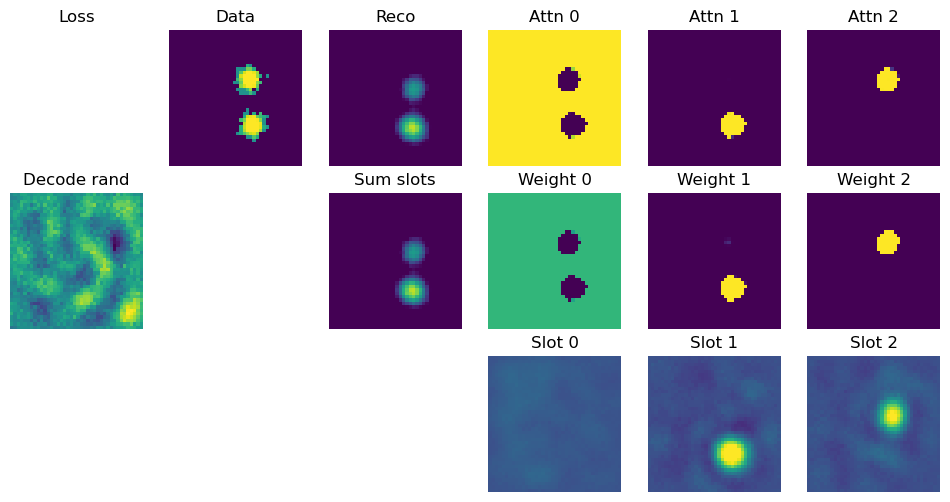

iter 250 , loss 1.1902467 , lr 1.4999999999999999e-05
tensor(1.0000e-08) tensor(0.1504) >>><<
tensor(1.0000e-08) tensor(0.1504) >>><<
tensor(1.0000e-08) tensor(0.1504) >>><<


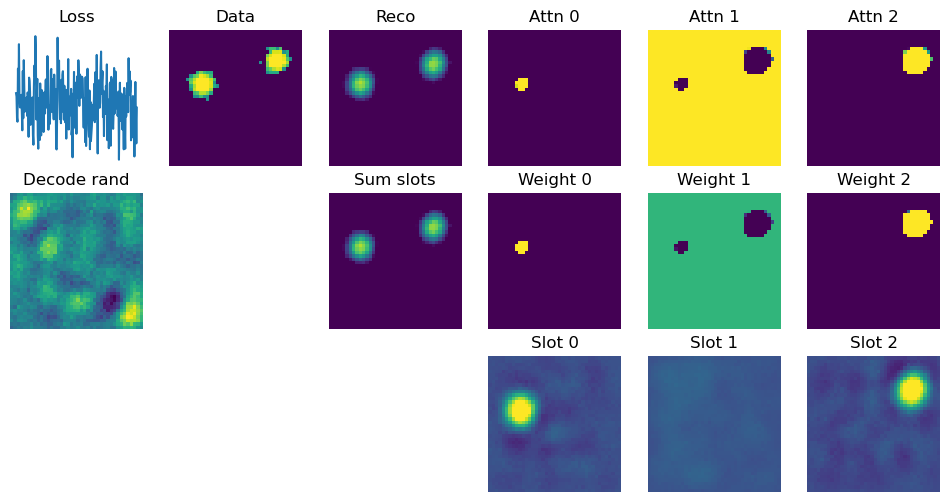

tensor(1.0000e-08) tensor(0.1743) >>><<
tensor(1.0000e-08) tensor(0.1743) >>><<
tensor(1.0000e-08) tensor(0.1743) >>><<


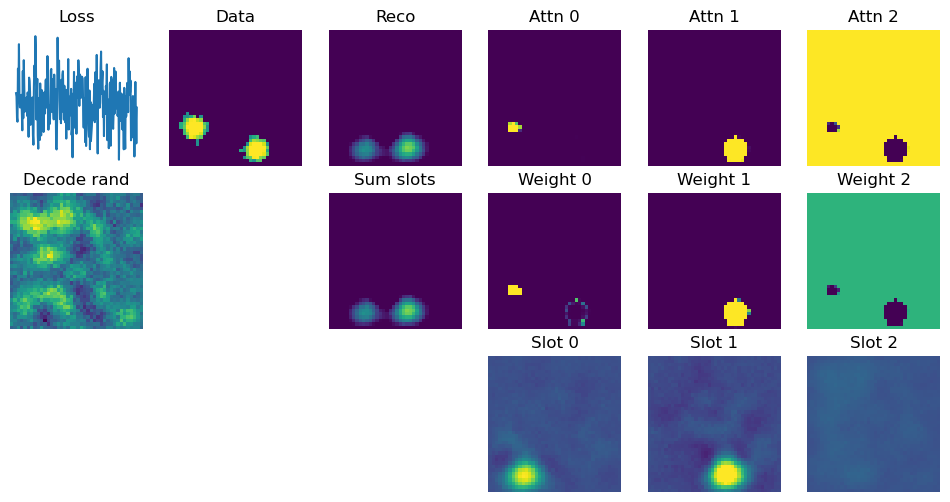

iter 500 , loss 1.5362827 , lr 2.9999999999999997e-05
tensor(1.0000e-08) tensor(0.1310) >>><<
tensor(1.0000e-08) tensor(0.1310) >>><<
tensor(1.0000e-08) tensor(0.1310) >>><<


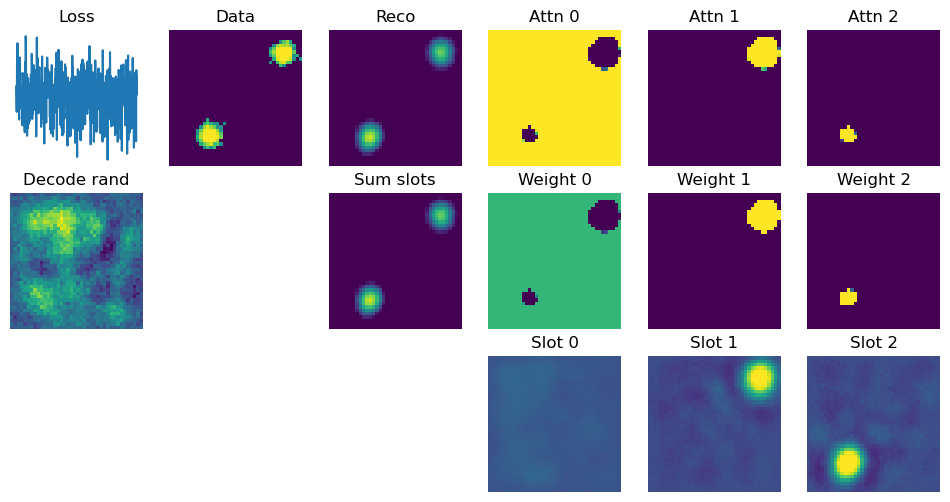

tensor(1.0000e-08) tensor(0.3084) >>><<
tensor(1.0000e-08) tensor(0.3084) >>><<
tensor(1.0000e-08) tensor(0.3084) >>><<


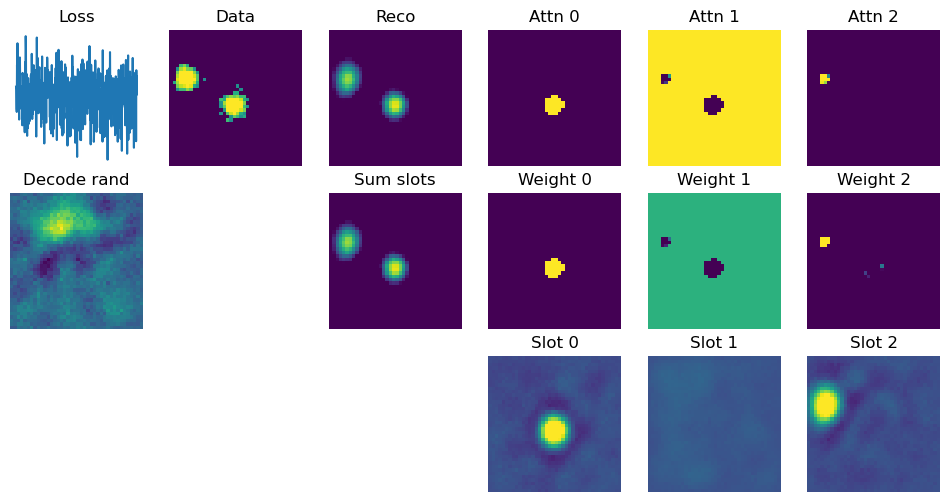

iter 750 , loss 1.0164604 , lr 4.4999999999999996e-05
tensor(1.0000e-08) tensor(0.2502) >>><<
tensor(1.0000e-08) tensor(0.2502) >>><<
tensor(1.0000e-08) tensor(0.2502) >>><<


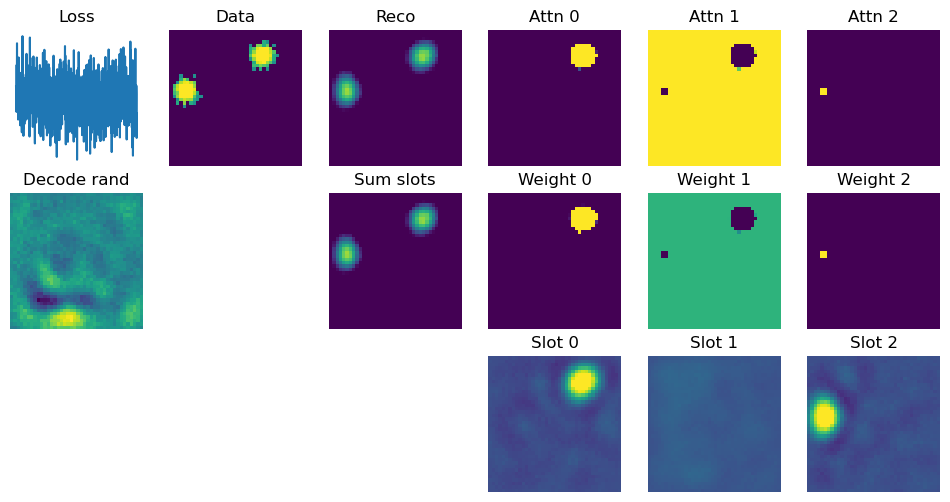

tensor(1.0000e-08) tensor(0.2580) >>><<
tensor(1.0000e-08) tensor(0.2580) >>><<
tensor(1.0000e-08) tensor(0.2580) >>><<


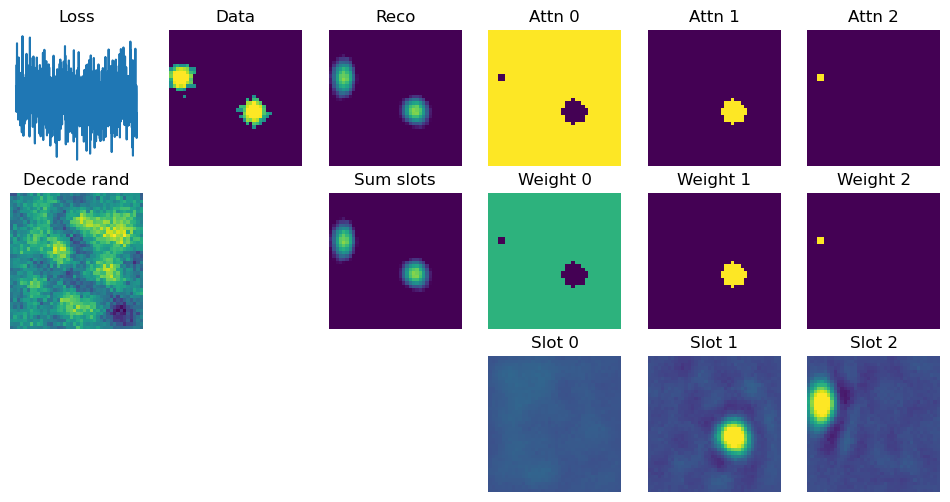

iter 1000 , loss 2.0264404 , lr 5.9999999999999995e-05
tensor(1.0000e-08) tensor(0.1890) >>><<
tensor(1.0000e-08) tensor(0.1890) >>><<
tensor(1.0000e-08) tensor(0.1890) >>><<


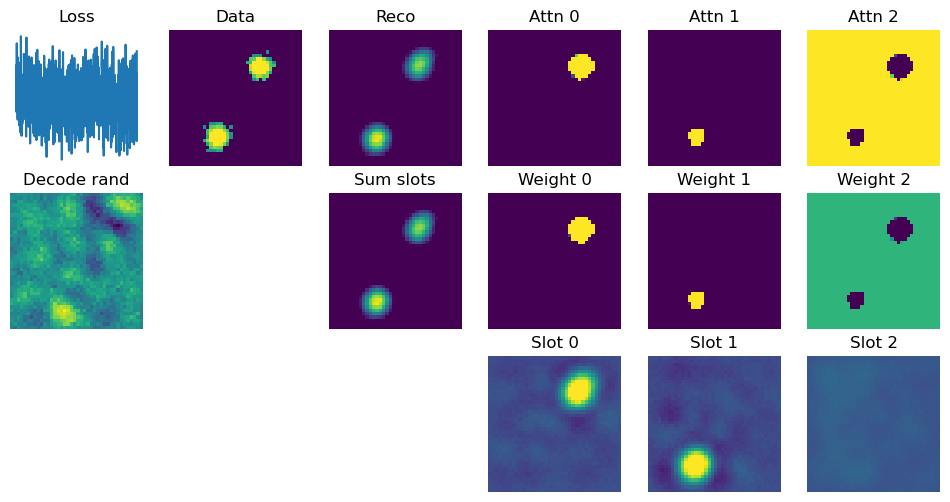

tensor(1.0000e-08) tensor(0.2011) >>><<
tensor(1.0000e-08) tensor(0.2011) >>><<
tensor(1.0000e-08) tensor(0.2011) >>><<


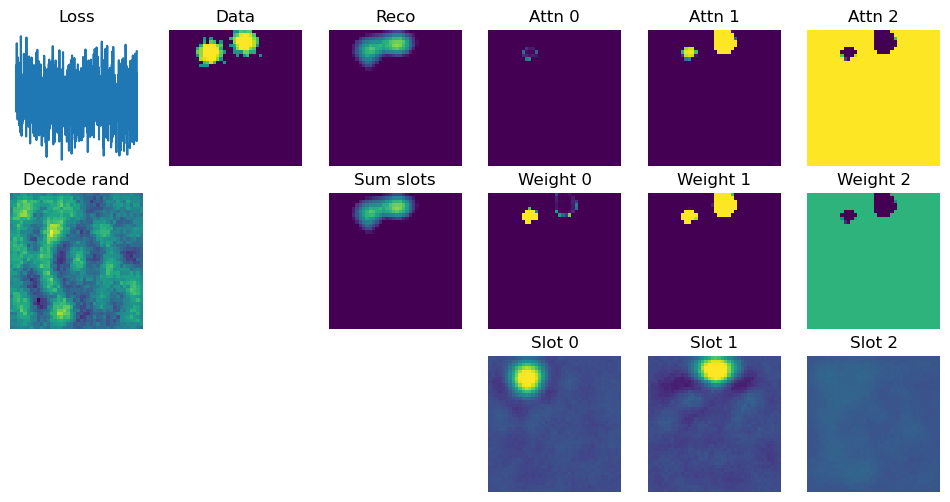

iter 1250 , loss 1.8105617 , lr 7.5e-05
tensor(1.0000e-08) tensor(0.2689) >>><<
tensor(1.0000e-08) tensor(0.2689) >>><<
tensor(1.0000e-08) tensor(0.2689) >>><<


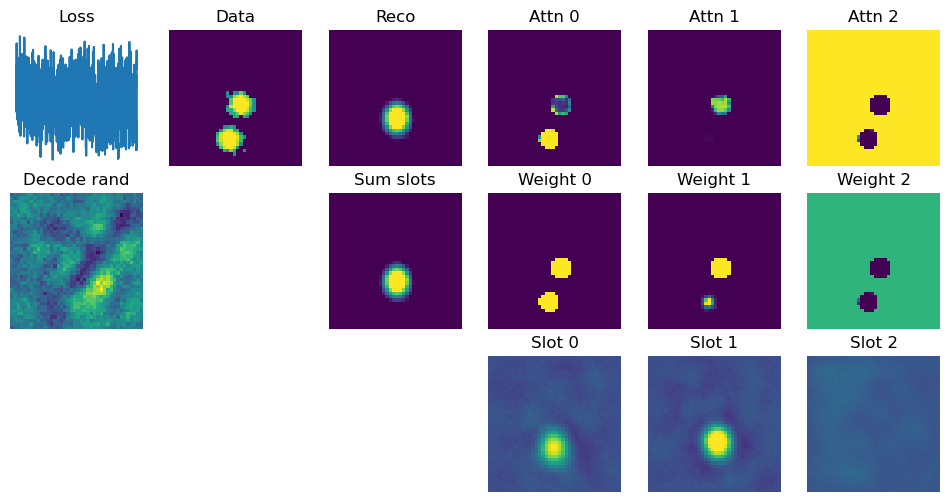

tensor(1.0000e-08) tensor(0.1910) >>><<
tensor(1.0000e-08) tensor(0.1910) >>><<
tensor(1.0000e-08) tensor(0.1910) >>><<


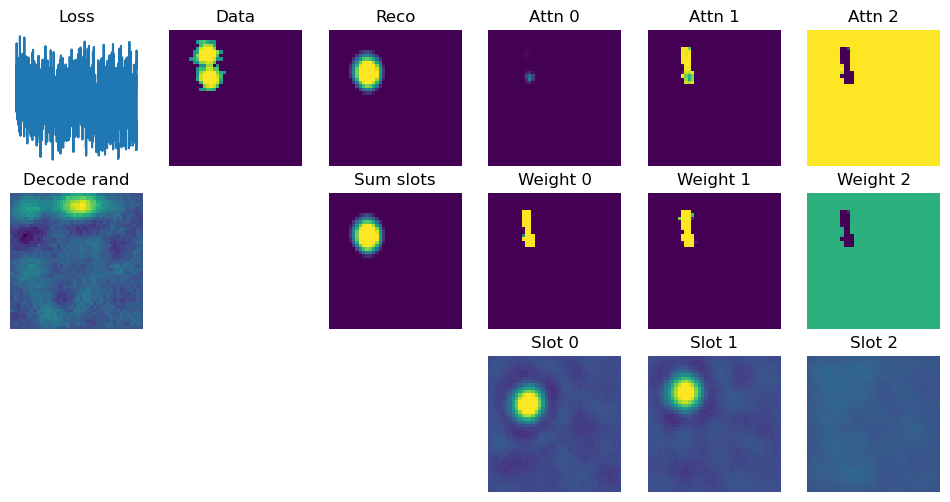

iter 1500 , loss 0.73043025 , lr 8.999999999999999e-05
tensor(1.0000e-08) tensor(0.4580) >>><<
tensor(1.0000e-08) tensor(0.4580) >>><<
tensor(1.0000e-08) tensor(0.4580) >>><<


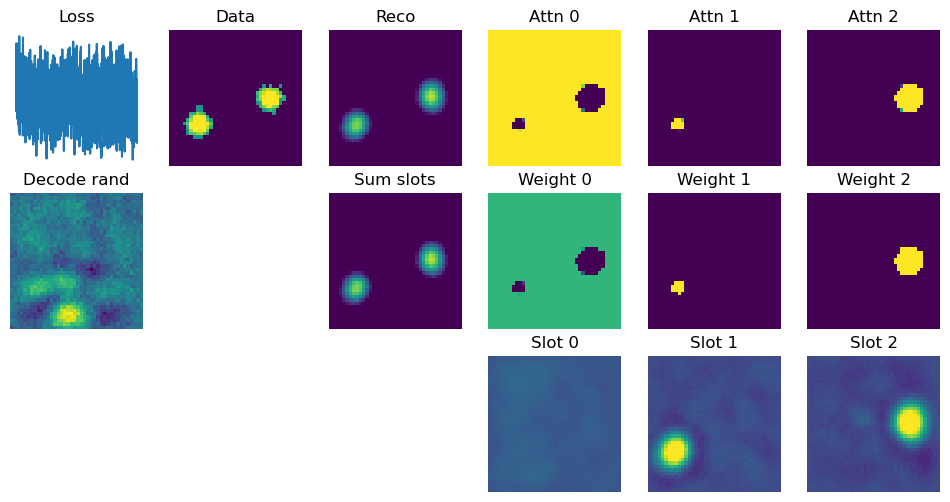

tensor(1.0000e-08) tensor(0.3978) >>><<
tensor(1.0000e-08) tensor(0.3978) >>><<
tensor(1.0000e-08) tensor(0.3978) >>><<


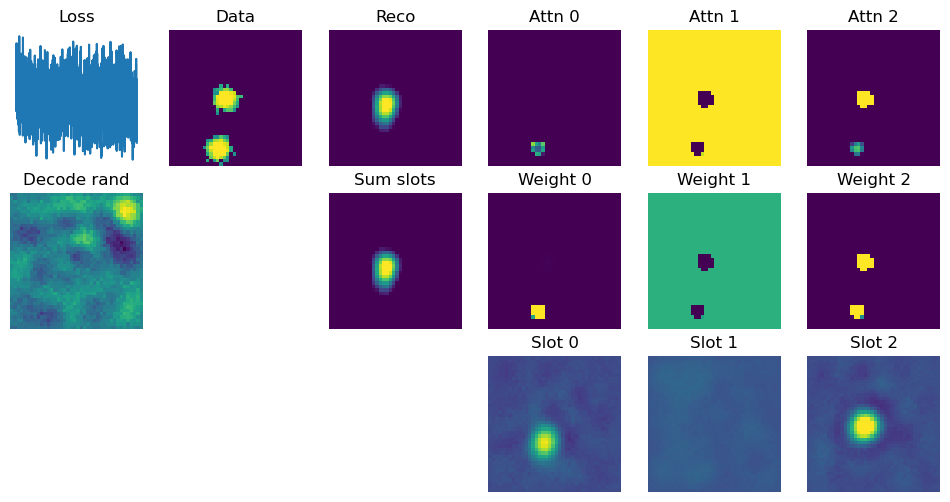

iter 1750 , loss 0.9921501 , lr 0.00010499999999999999
tensor(1.0000e-08) tensor(0.0969) >>><<
tensor(1.0000e-08) tensor(0.0969) >>><<
tensor(1.0000e-08) tensor(0.0969) >>><<


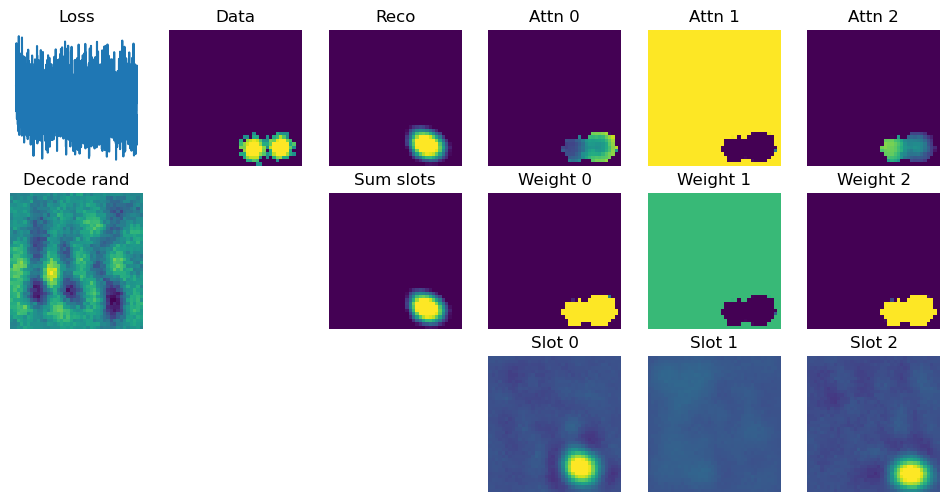

tensor(1.0000e-08) tensor(0.0953) >>><<
tensor(1.0000e-08) tensor(0.0953) >>><<
tensor(1.0000e-08) tensor(0.0953) >>><<


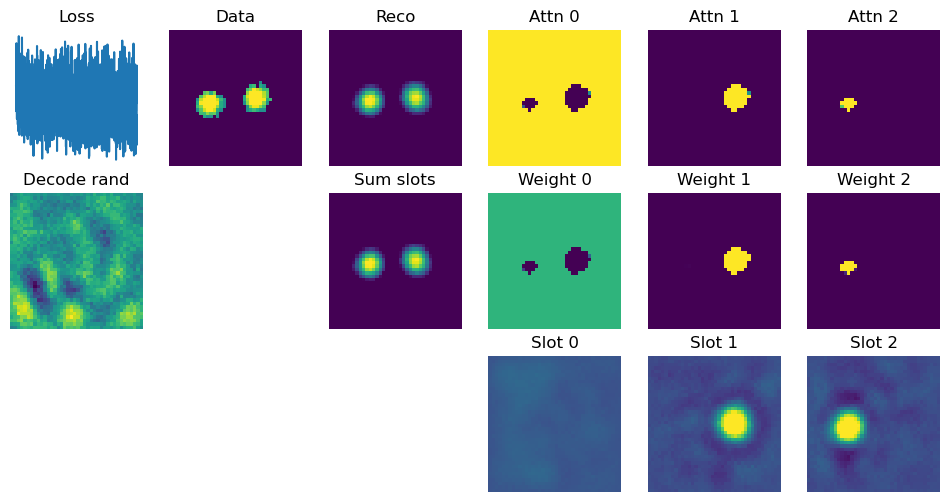

iter 2000 , loss 1.519569 , lr 0.00011999999999999999
tensor(1.0000e-08) tensor(0.4400) >>><<
tensor(1.0000e-08) tensor(0.4400) >>><<
tensor(1.0000e-08) tensor(0.4400) >>><<


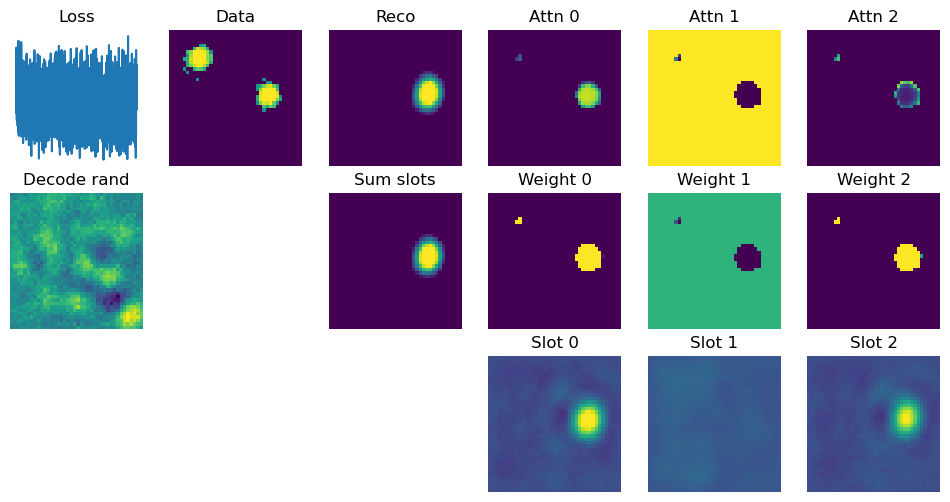

tensor(1.0000e-08) tensor(0.3158) >>><<
tensor(1.0000e-08) tensor(0.3158) >>><<
tensor(1.0000e-08) tensor(0.3158) >>><<


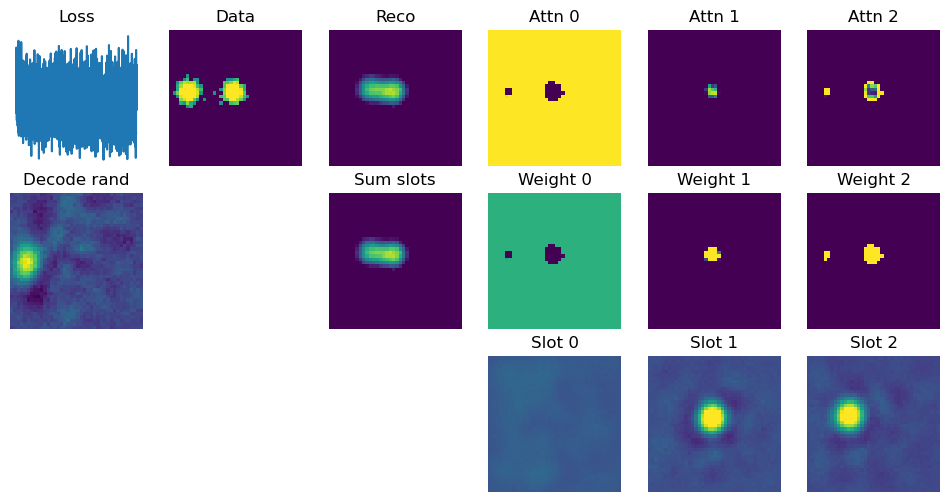

iter 2250 , loss 1.1951808 , lr 0.000135
tensor(1.0000e-08) tensor(0.2516) >>><<
tensor(1.0000e-08) tensor(0.2516) >>><<
tensor(1.0000e-08) tensor(0.2516) >>><<


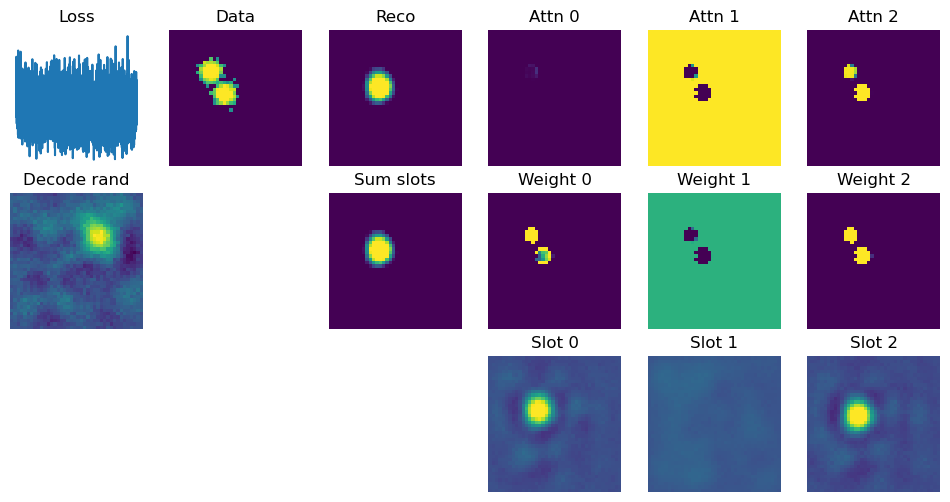

tensor(1.0000e-08) tensor(0.2620) >>><<
tensor(1.0000e-08) tensor(0.2620) >>><<
tensor(1.0000e-08) tensor(0.2620) >>><<


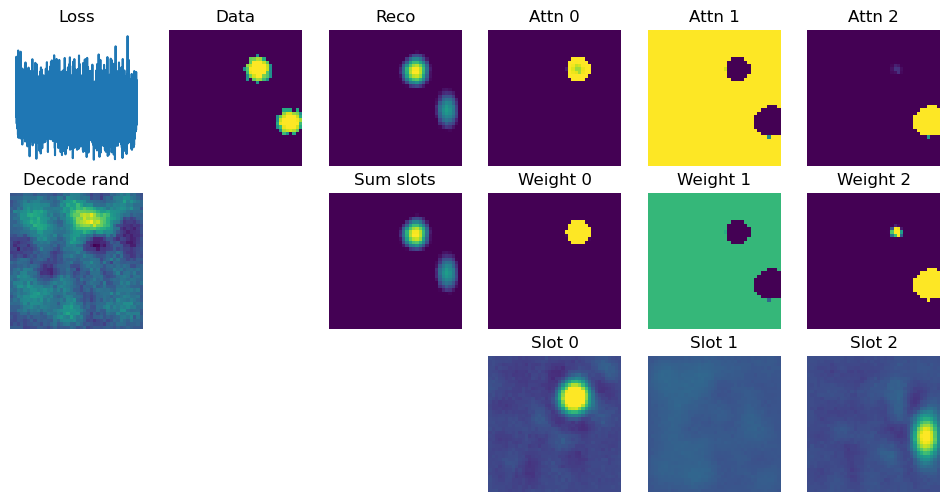

iter 2500 , loss 1.736864 , lr 0.00015
tensor(1.0000e-08) tensor(0.1417) >>><<
tensor(1.0000e-08) tensor(0.1417) >>><<
tensor(1.0000e-08) tensor(0.1417) >>><<


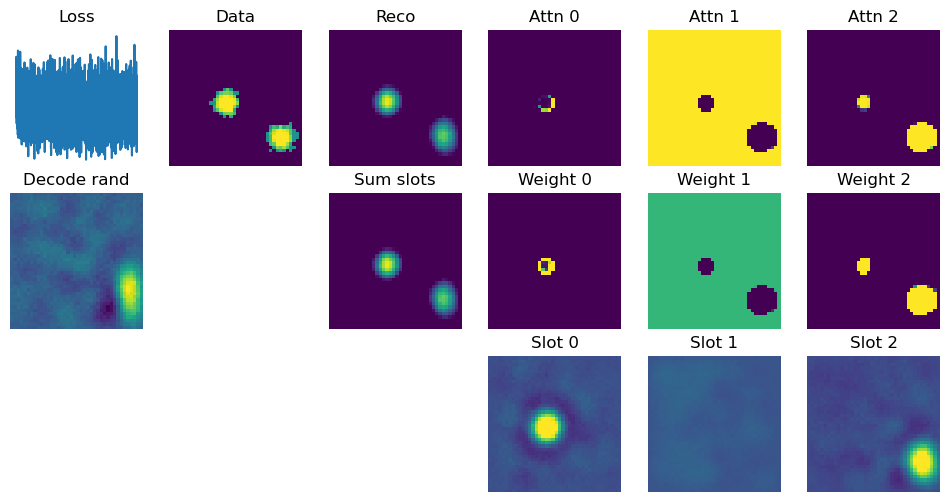

tensor(1.0000e-08) tensor(0.0616) >>><<
tensor(1.0000e-08) tensor(0.0616) >>><<
tensor(1.0000e-08) tensor(0.0616) >>><<


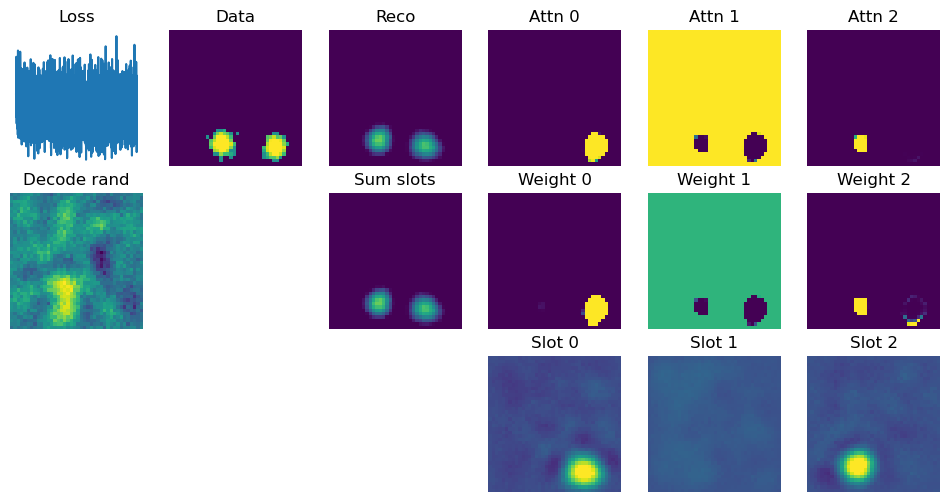

iter 2750 , loss 1.5990866 , lr 0.000165
tensor(1.0000e-08) tensor(0.1866) >>><<
tensor(1.0000e-08) tensor(0.1866) >>><<
tensor(1.0000e-08) tensor(0.1866) >>><<


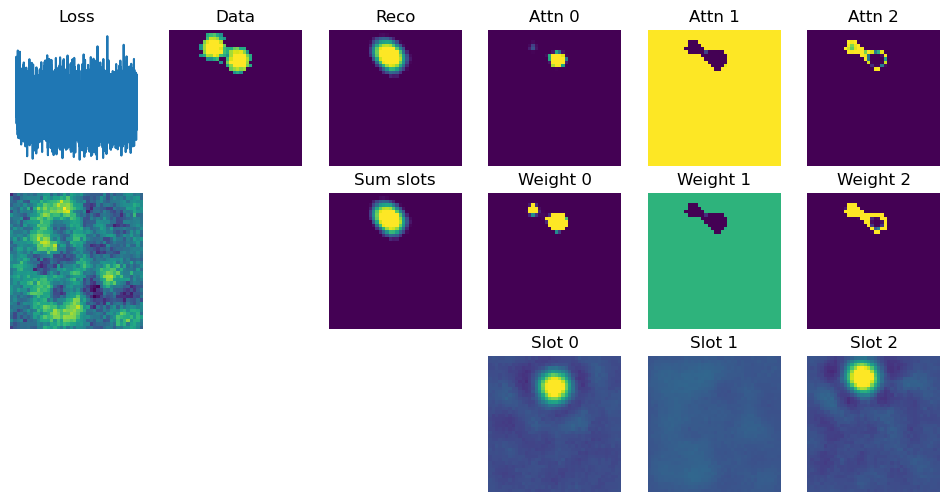

tensor(1.0000e-08) tensor(0.2958) >>><<
tensor(1.0000e-08) tensor(0.2958) >>><<
tensor(1.0000e-08) tensor(0.2958) >>><<


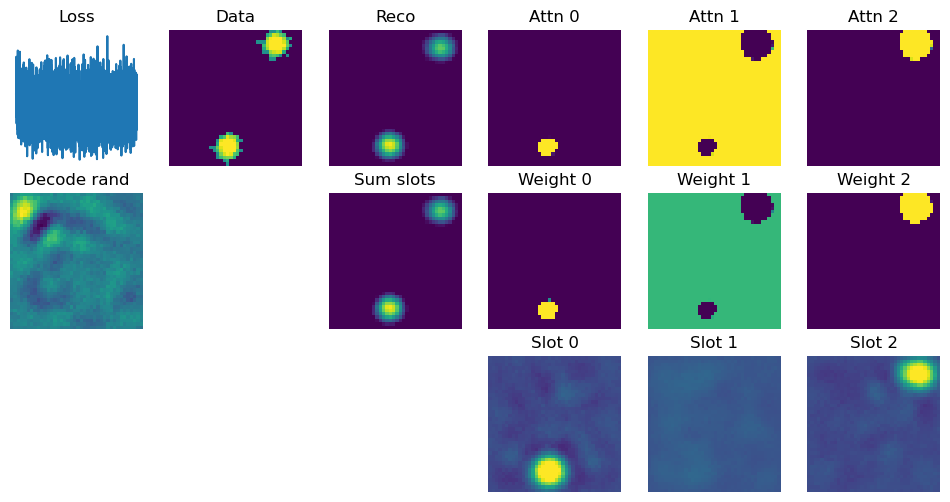

iter 3000 , loss 1.3396688 , lr 0.00017999999999999998
tensor(1.0000e-08) tensor(0.5711) >>><<
tensor(1.0000e-08) tensor(0.5711) >>><<
tensor(1.0000e-08) tensor(0.5711) >>><<


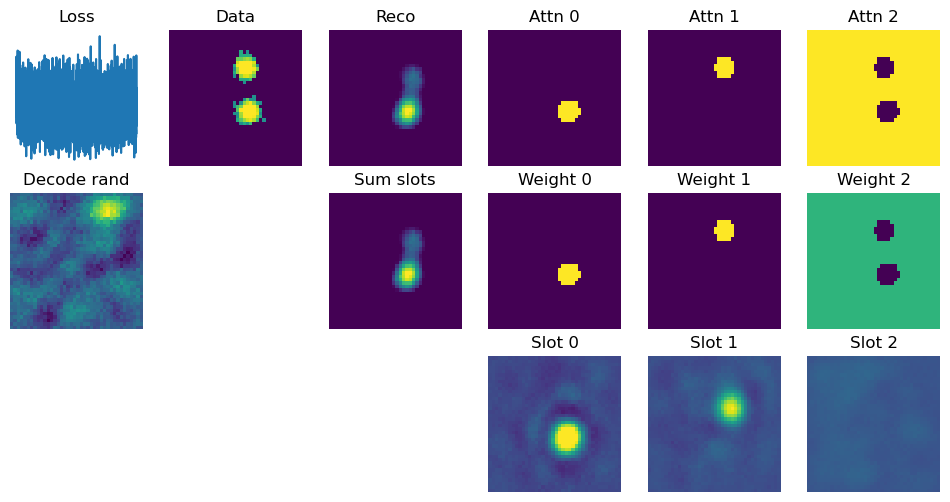

tensor(1.0000e-08) tensor(0.0941) >>><<
tensor(1.0000e-08) tensor(0.0941) >>><<
tensor(1.0000e-08) tensor(0.0941) >>><<


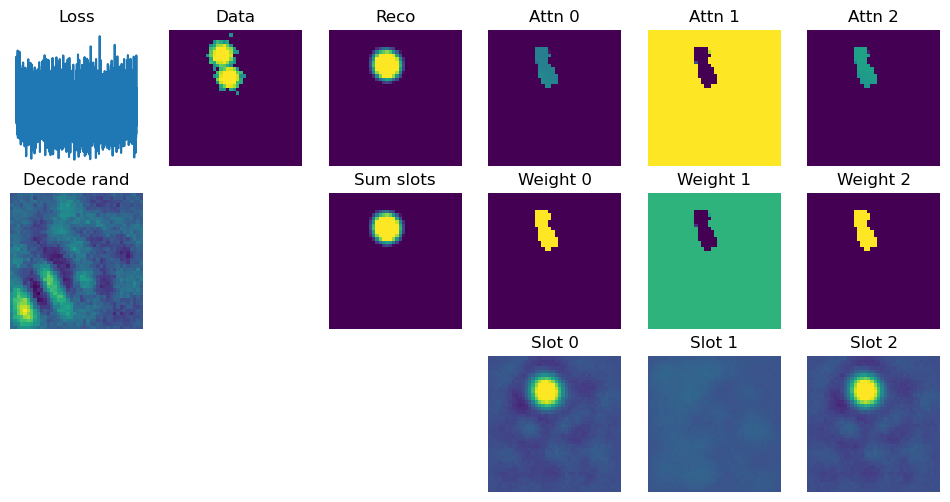

iter 3250 , loss 1.0114396 , lr 0.000195
tensor(1.0000e-08) tensor(0.0909) >>><<
tensor(1.0000e-08) tensor(0.0909) >>><<
tensor(1.0000e-08) tensor(0.0909) >>><<


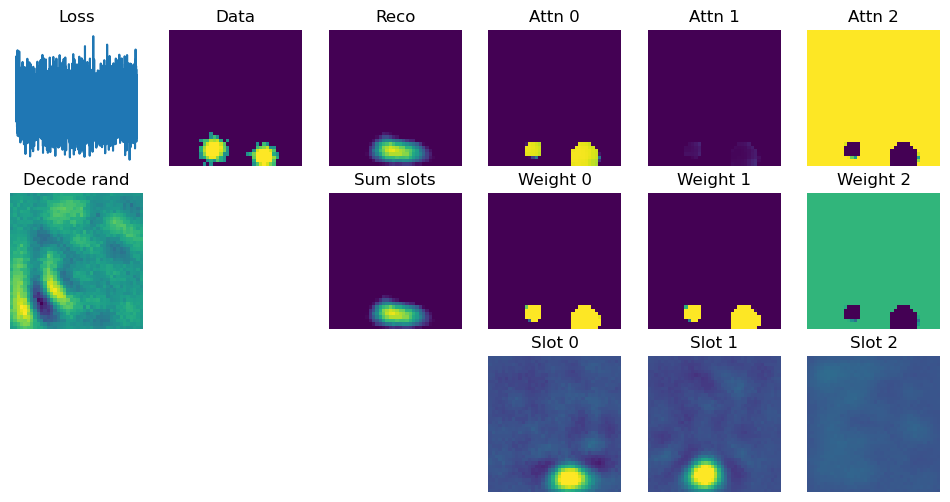

tensor(1.0000e-08) tensor(0.5069) >>><<
tensor(1.0000e-08) tensor(0.5069) >>><<
tensor(1.0000e-08) tensor(0.5069) >>><<


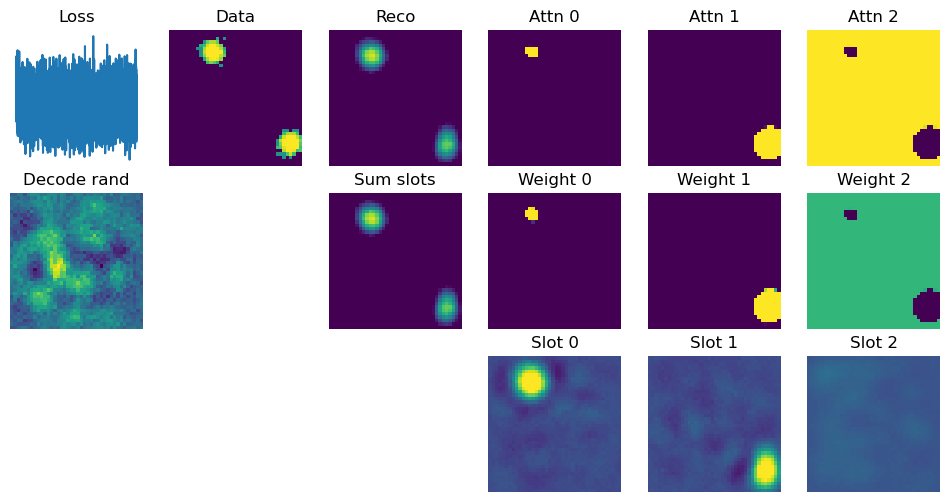

iter 3500 , loss 1.373841 , lr 0.00020999999999999998
tensor(1.0000e-08) tensor(0.1355) >>><<
tensor(1.0000e-08) tensor(0.1355) >>><<
tensor(1.0000e-08) tensor(0.1355) >>><<


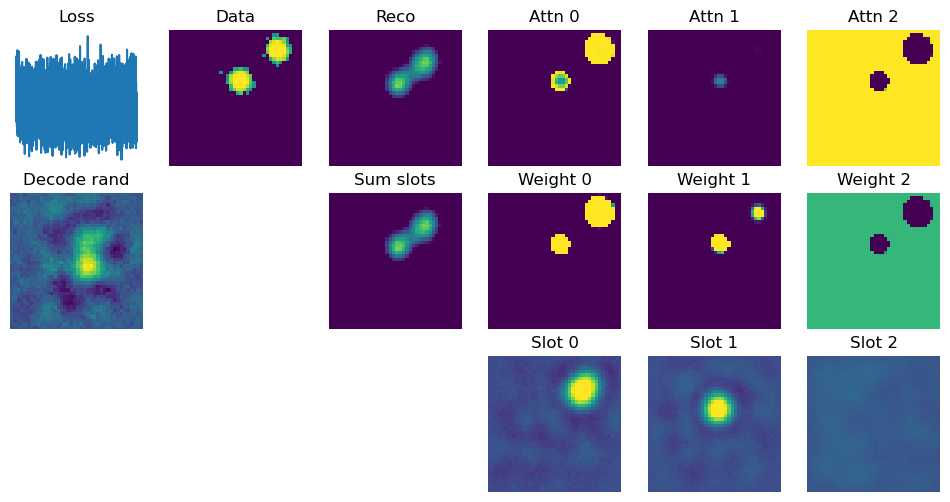

tensor(1.0000e-08) tensor(0.1585) >>><<
tensor(1.0000e-08) tensor(0.1585) >>><<
tensor(1.0000e-08) tensor(0.1585) >>><<


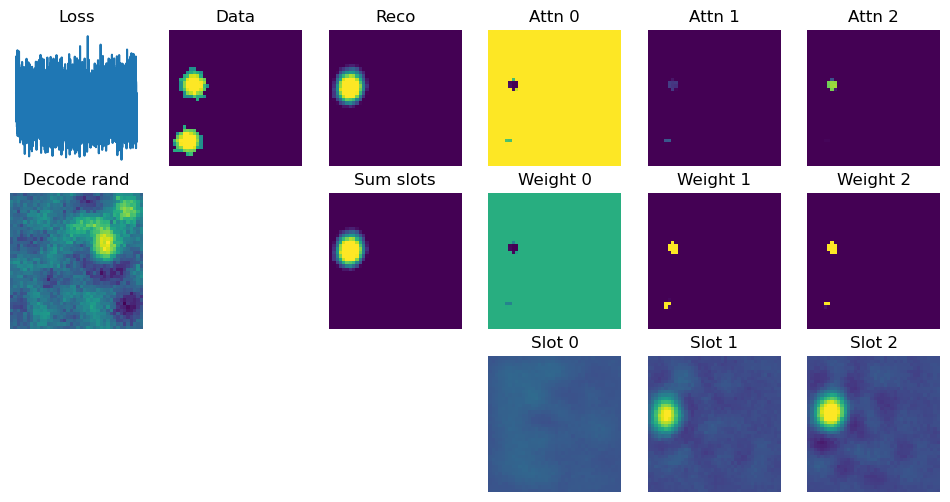

iter 3750 , loss 0.8214882 , lr 0.000225
tensor(1.0000e-08) tensor(0.0927) >>><<
tensor(1.0000e-08) tensor(0.0927) >>><<
tensor(1.0000e-08) tensor(0.0927) >>><<


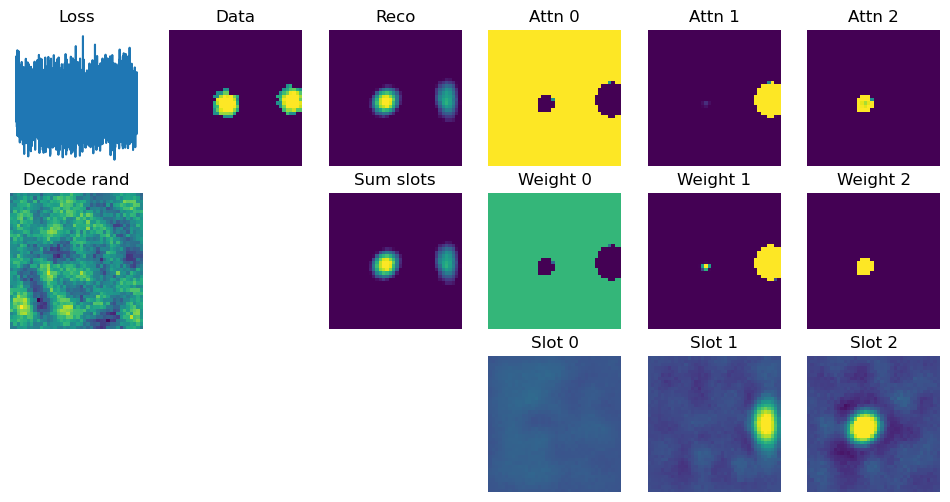

tensor(1.0000e-08) tensor(0.1551) >>><<
tensor(1.0000e-08) tensor(0.1551) >>><<
tensor(1.0000e-08) tensor(0.1551) >>><<


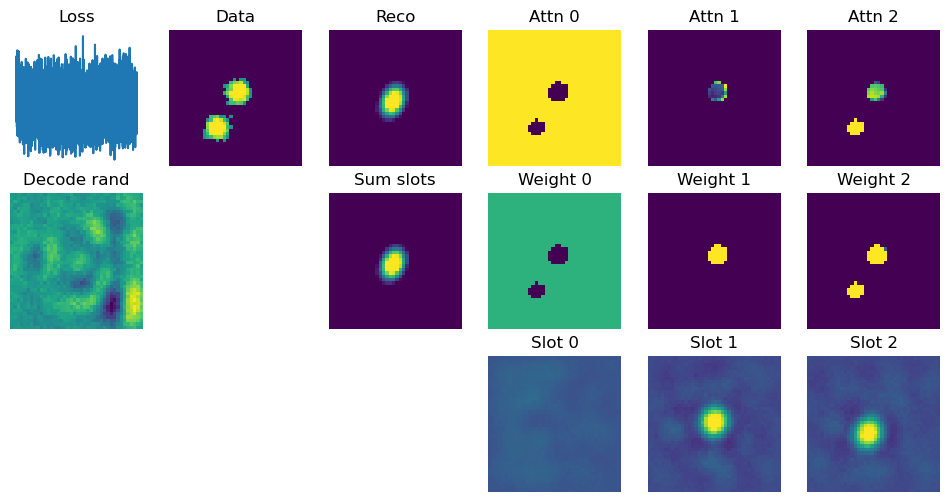

iter 4000 , loss 0.9473124 , lr 0.00023999999999999998
tensor(1.0000e-08) tensor(0.1776) >>><<
tensor(1.0000e-08) tensor(0.1776) >>><<
tensor(1.0000e-08) tensor(0.1776) >>><<


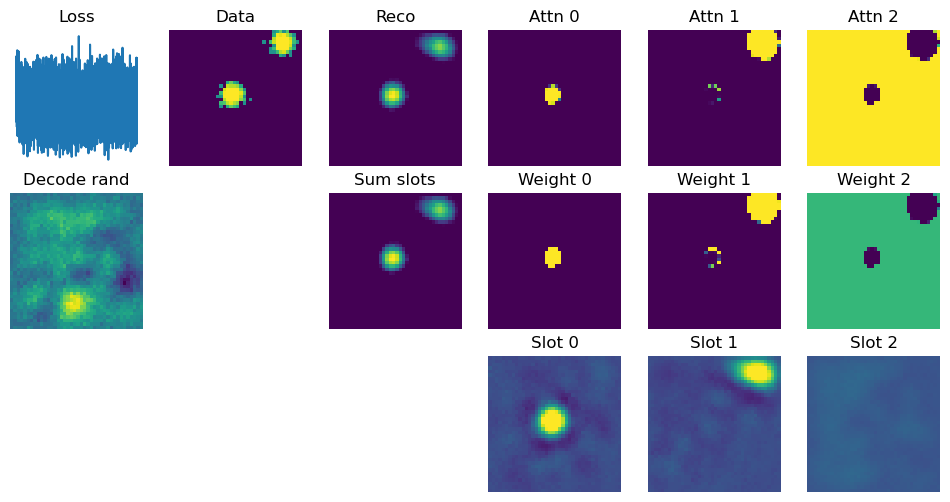

tensor(1.0000e-08) tensor(0.1645) >>><<
tensor(1.0000e-08) tensor(0.1645) >>><<
tensor(1.0000e-08) tensor(0.1645) >>><<


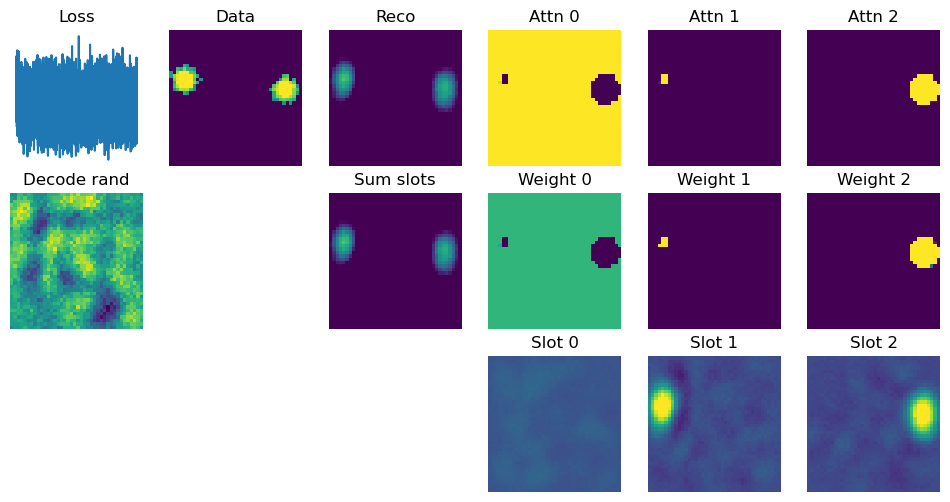

iter 4250 , loss 1.9678875 , lr 0.00025499999999999996
tensor(1.0000e-08) tensor(0.1113) >>><<
tensor(1.0000e-08) tensor(0.1113) >>><<
tensor(1.0000e-08) tensor(0.1113) >>><<


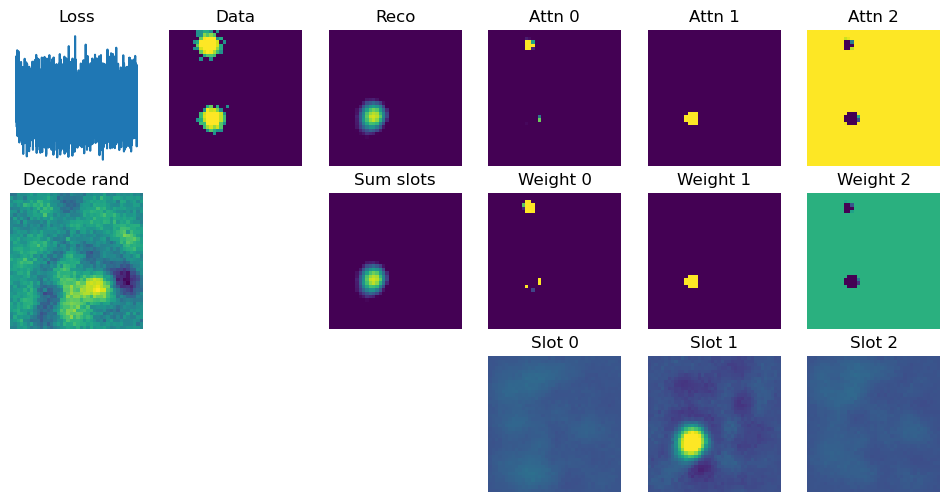

tensor(1.0000e-08) tensor(0.1429) >>><<
tensor(1.0000e-08) tensor(0.1429) >>><<
tensor(1.0000e-08) tensor(0.1429) >>><<


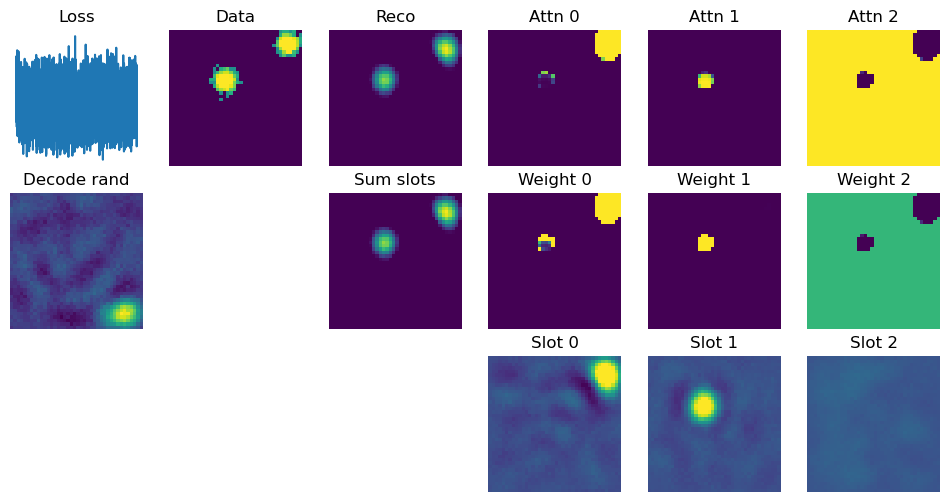

iter 4500 , loss 1.4692733 , lr 0.00027
tensor(1.0000e-08) tensor(0.2789) >>><<
tensor(1.0000e-08) tensor(0.2789) >>><<
tensor(1.0000e-08) tensor(0.2789) >>><<


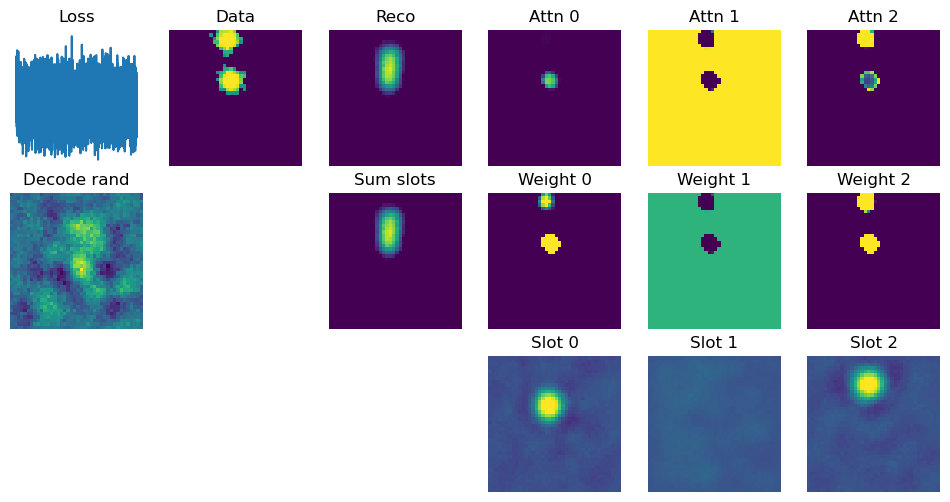

tensor(1.0000e-08) tensor(0.2293) >>><<
tensor(1.0000e-08) tensor(0.2293) >>><<
tensor(1.0000e-08) tensor(0.2293) >>><<


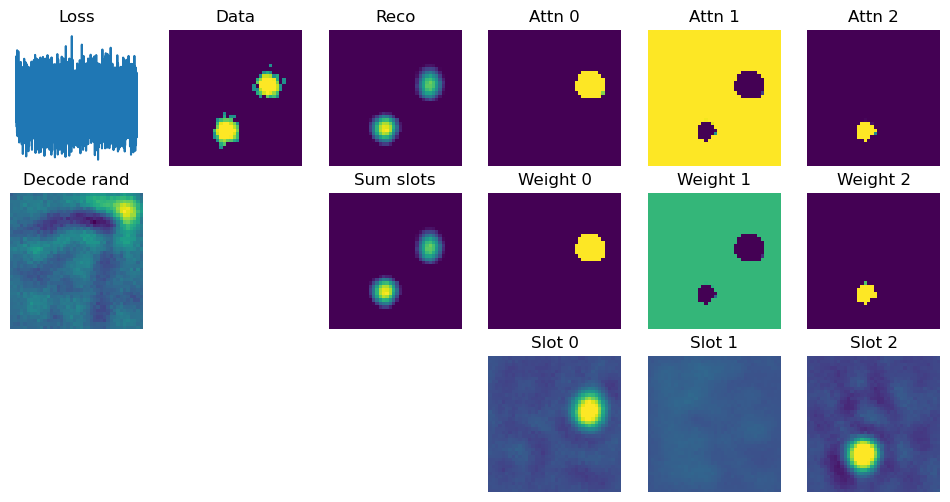

iter 4750 , loss 0.8217275 , lr 0.000285
tensor(1.0000e-08) tensor(0.1189) >>><<
tensor(1.0000e-08) tensor(0.1189) >>><<
tensor(1.0000e-08) tensor(0.1189) >>><<


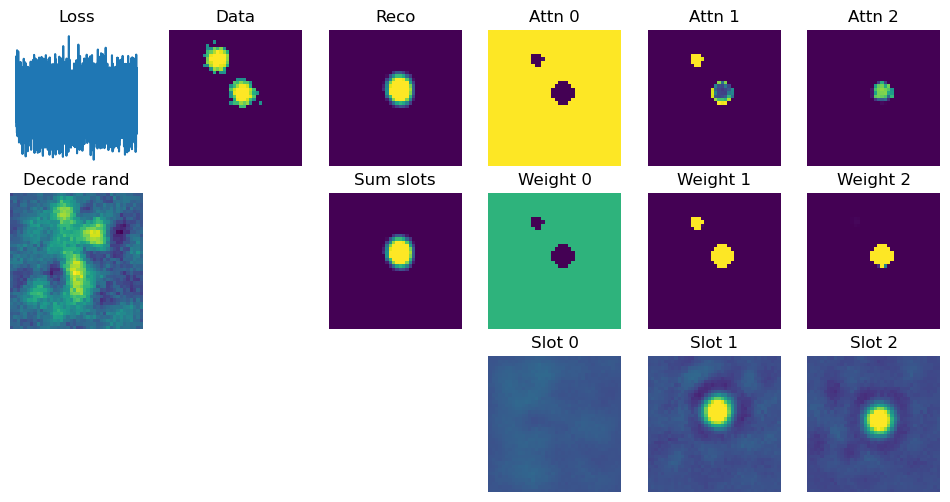

tensor(1.0000e-08) tensor(0.1661) >>><<
tensor(1.0000e-08) tensor(0.1661) >>><<
tensor(1.0000e-08) tensor(0.1661) >>><<


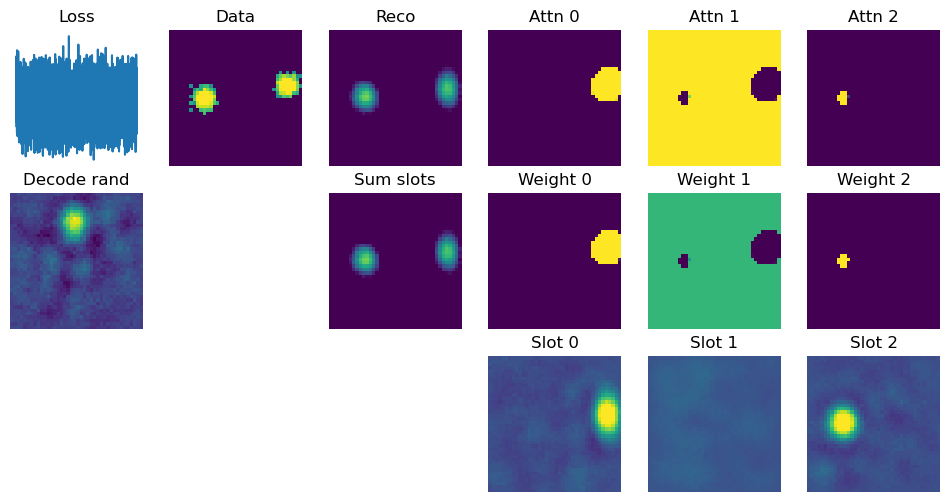

iter 5000 , loss 1.3588895 , lr 0.0003
tensor(1.0000e-08) tensor(0.4070) >>><<
tensor(1.0000e-08) tensor(0.4070) >>><<
tensor(1.0000e-08) tensor(0.4070) >>><<


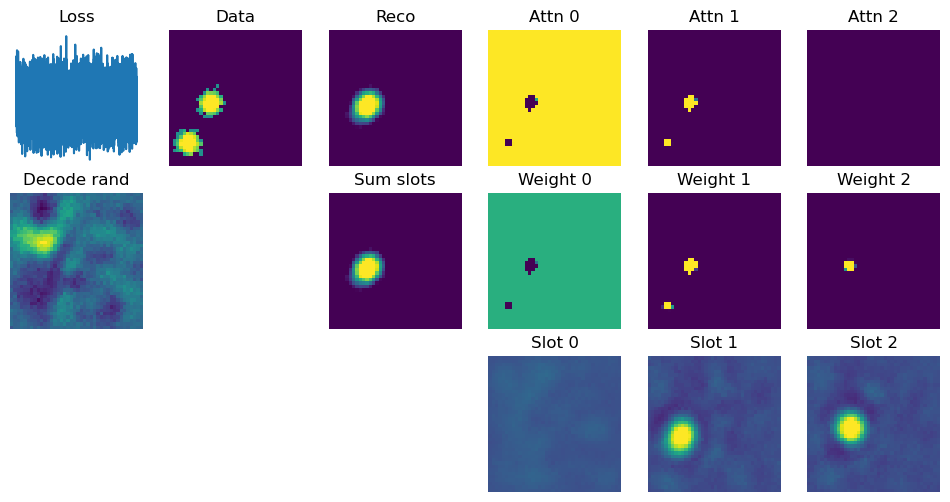

tensor(1.0000e-08) tensor(0.4533) >>><<
tensor(1.0000e-08) tensor(0.4533) >>><<
tensor(1.0000e-08) tensor(0.4533) >>><<


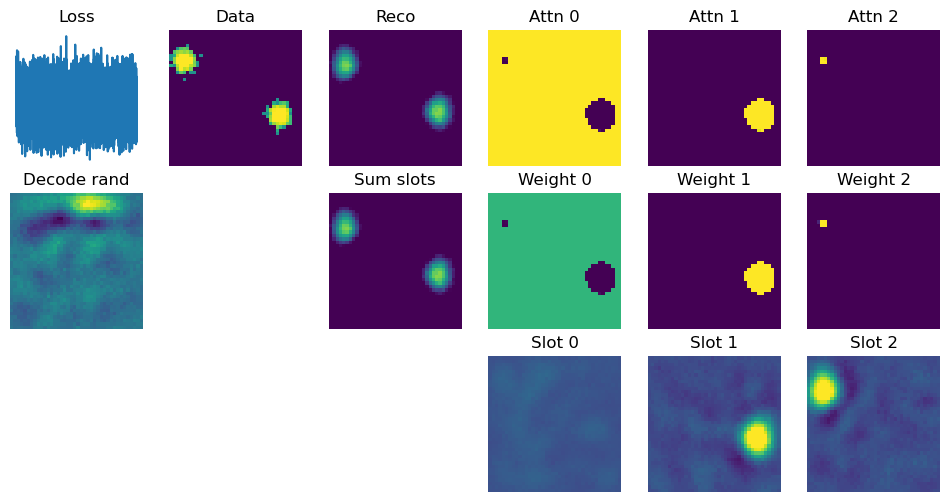

iter 5250 , loss 0.95819455 , lr 0.0003
tensor(1.0000e-08) tensor(0.0667) >>><<
tensor(1.0000e-08) tensor(0.0667) >>><<
tensor(1.0000e-08) tensor(0.0667) >>><<


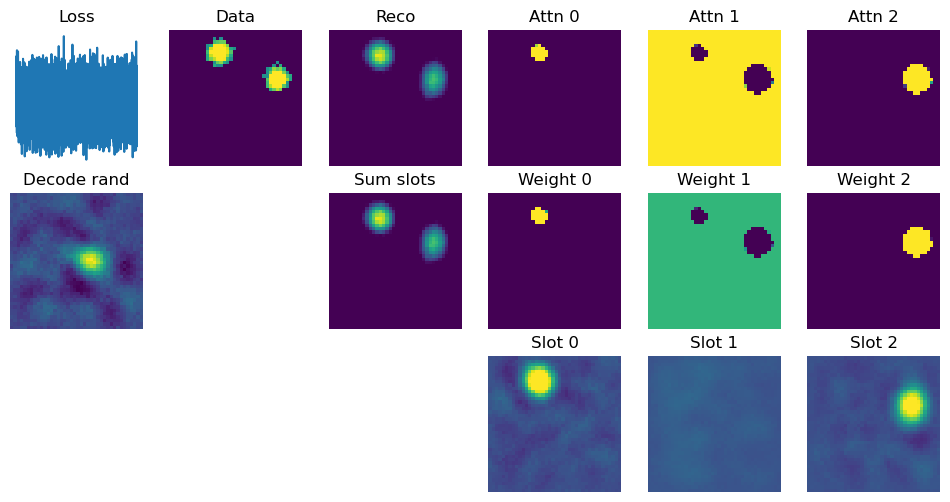

tensor(1.0000e-08) tensor(0.0731) >>><<
tensor(1.0000e-08) tensor(0.0731) >>><<
tensor(1.0000e-08) tensor(0.0731) >>><<


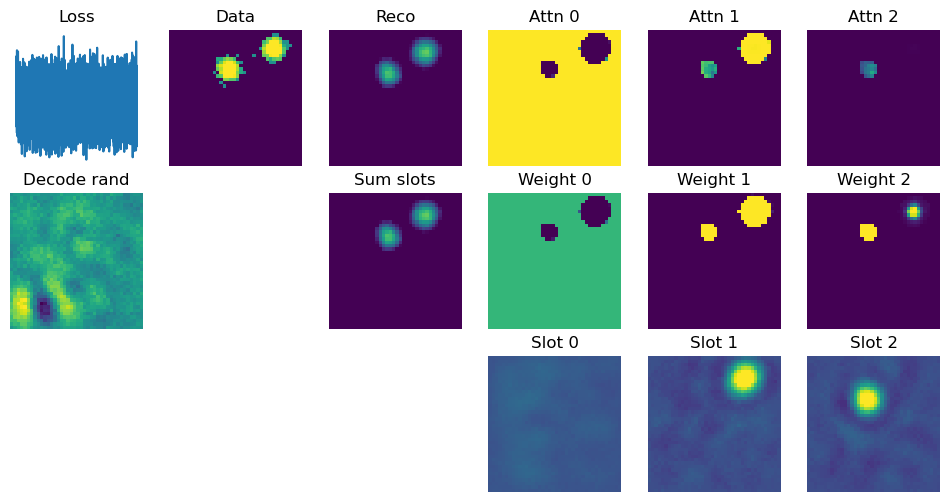

iter 5500 , loss 1.3786683 , lr 0.0003
tensor(1.0000e-08) tensor(0.2500) >>><<
tensor(1.0000e-08) tensor(0.2500) >>><<
tensor(1.0000e-08) tensor(0.2500) >>><<


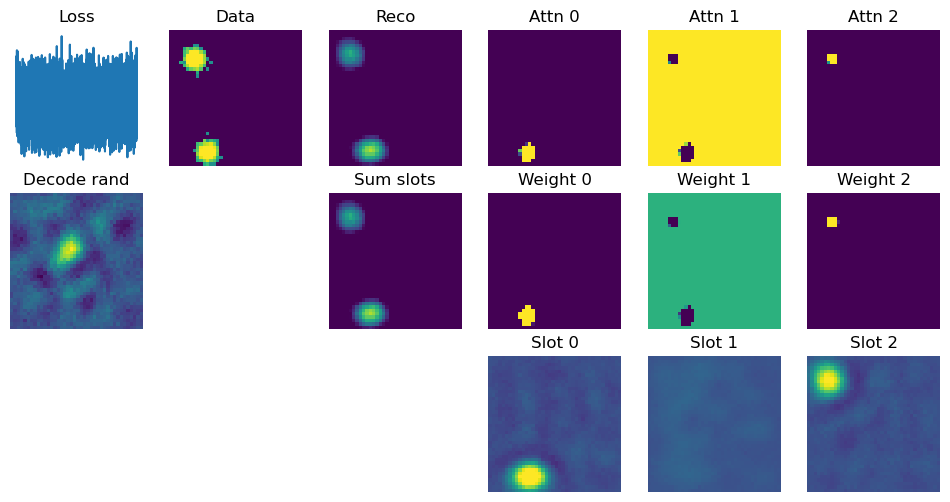

tensor(1.0000e-08) tensor(0.2500) >>><<
tensor(1.0000e-08) tensor(0.2500) >>><<
tensor(1.0000e-08) tensor(0.2500) >>><<


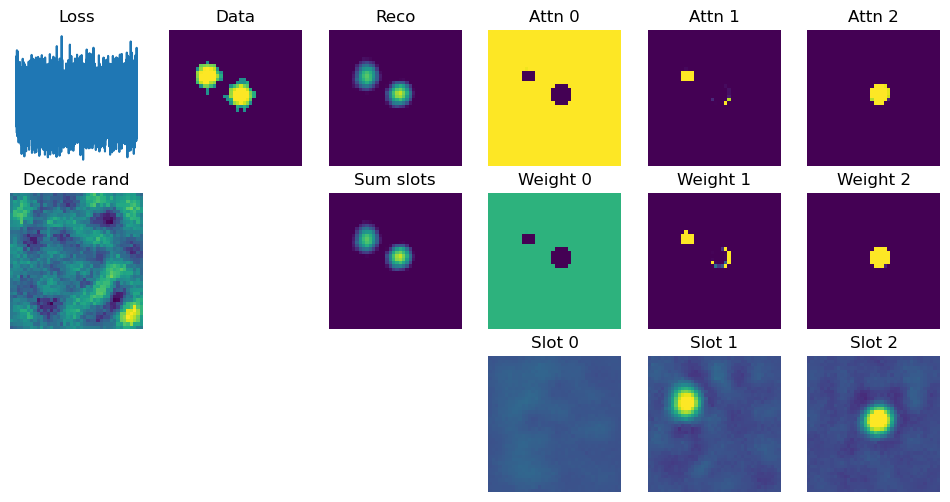

iter 5750 , loss 1.6464064 , lr 0.0003
tensor(1.0000e-08) tensor(0.0667) >>><<
tensor(1.0000e-08) tensor(0.0667) >>><<
tensor(1.0000e-08) tensor(0.0667) >>><<


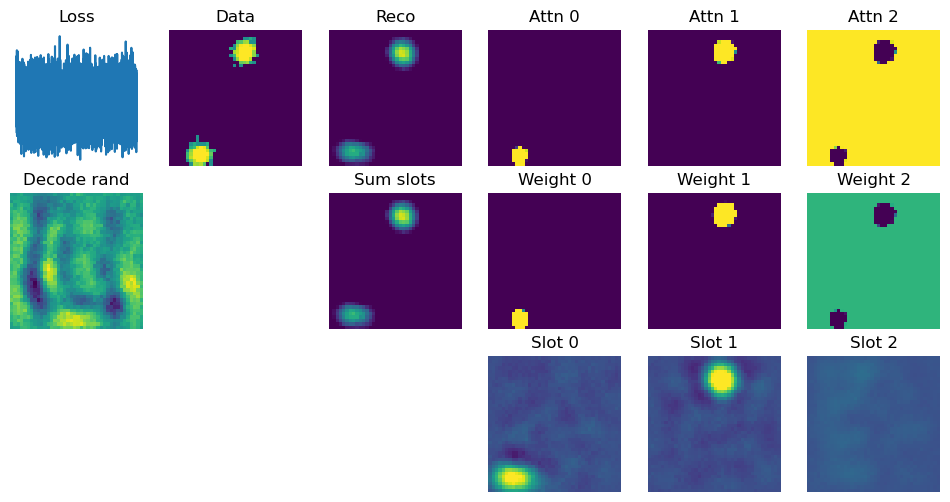

tensor(1.0000e-08) tensor(0.1225) >>><<
tensor(1.0000e-08) tensor(0.1225) >>><<
tensor(1.0000e-08) tensor(0.1225) >>><<


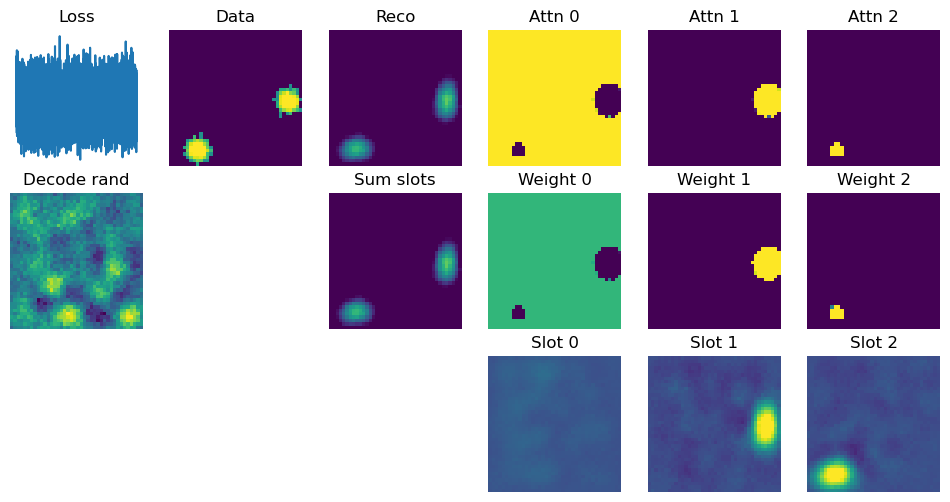

iter 6000 , loss 0.8810366 , lr 0.0003
tensor(1.0000e-08) tensor(0.1263) >>><<
tensor(1.0000e-08) tensor(0.1263) >>><<
tensor(1.0000e-08) tensor(0.1263) >>><<


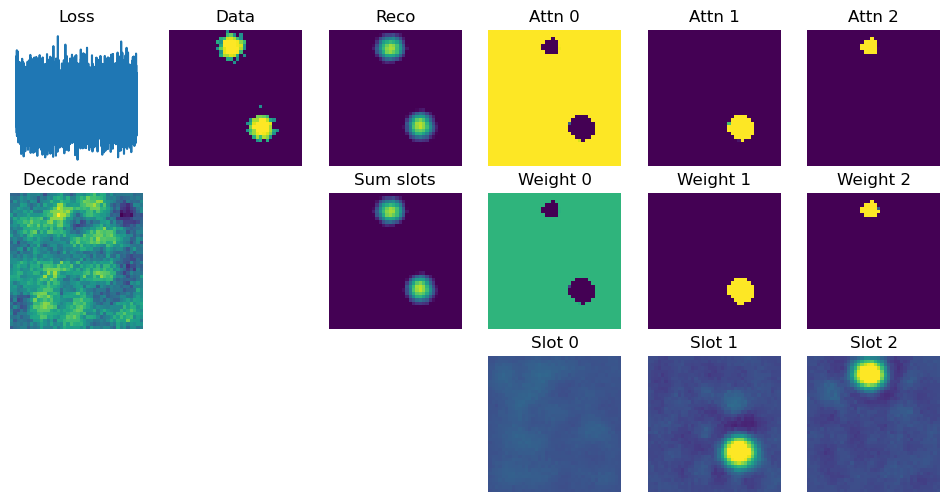

tensor(1.0000e-08) tensor(0.1289) >>><<
tensor(1.0000e-08) tensor(0.1289) >>><<
tensor(1.0000e-08) tensor(0.1289) >>><<


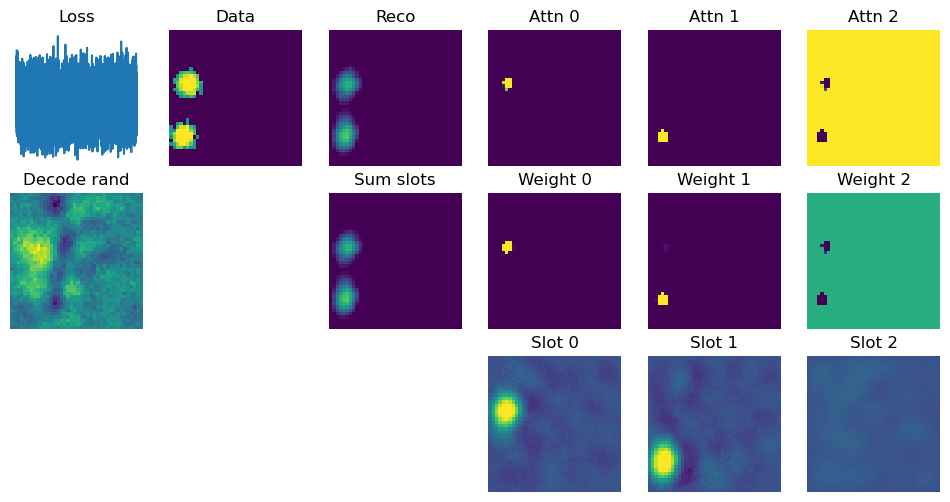

iter 6250 , loss 1.0298414 , lr 0.0003
tensor(1.0000e-08) tensor(0.1581) >>><<
tensor(1.0000e-08) tensor(0.1581) >>><<
tensor(1.0000e-08) tensor(0.1581) >>><<


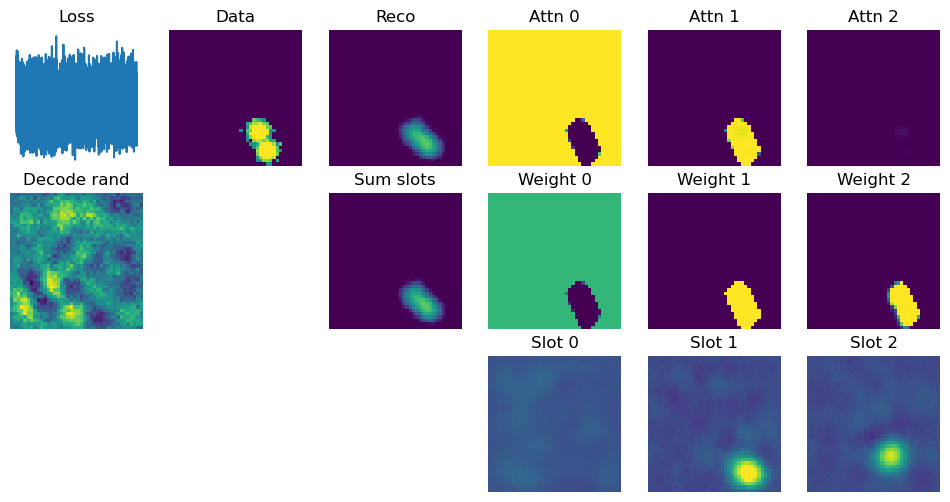

tensor(1.0000e-08) tensor(0.0831) >>><<
tensor(1.0000e-08) tensor(0.0831) >>><<
tensor(1.0000e-08) tensor(0.0831) >>><<


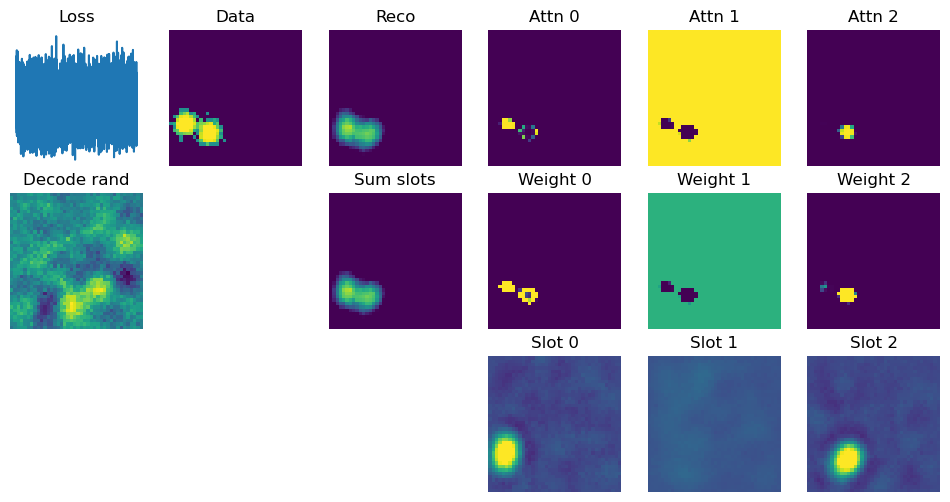

In [24]:
# model,*_rest = train(model,40_000)
model,*_rest = train(model,6_500)